In [1284]:
# Author: Banafsheh Khazali
# Date: June 5, 2023

Step 3, Systematically destroying the network

In [1285]:
import time
import os

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import integrate, signal, sparse, linalg
from threading import Thread

import seaborn as sns


In [1286]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1287]:
output_values = []

""" Number of Neurons """
N = 279

""" Cell membrane conductance (pS) """
Gc = 0.1

""" Cell Membrane Capacitance """
C = 0.015

""" Gap Junctions (Electrical, 279*279) """
ggap = 1.0
Gg_Static = np.load('/content/drive/MyDrive/connectome/Gg.npy')

""" Synaptic connections (Chemical, 279*279) """
gsyn = 1.0
Gs_Static = np.load('/content/drive/MyDrive/connectome/Gs.npy')

""" Leakage potential (mV) """
Ec = -35.0

""" Directionality (279*1) """
E = np.load('/content/drive/MyDrive/connectome/emask.npy')
E = -48.0 * E
EMat = np.tile(np.reshape(E, N), (N, 1))

""" Synaptic Activity Parameters """
ar = 1.0/1.5 # Synaptic activity's rise time
ad = 5.0/1.5 # Synaptic activity's decay time
B = 0.125 # Width of the sigmoid (mv^-1)

""" Input_Mask/Continuous Transtion """
transit_Mat = np.zeros((2, N))

t_Tracker = 0
Iext = 100000

rate = 0.025
offset = 0.15

t_Switch = 0
transit_End = 10
     

""" Connectome Arrays """
Gg_Dynamic = Gg_Static.copy()
Gs_Dynamic = Gs_Static.copy()

""" Data matrix stack size """
stack_Size = 5000
init_data_Mat = np.zeros((stack_Size + 5000, N))
data_Mat = np.zeros((stack_Size, N))

InMask = np.zeros(N)
oldMask = np.zeros(N)
newMask = np.zeros(N) 



In [1288]:

""" Mask transition """
def transit_Mask(input_Array):

    global t_Switch, oldMask, newMask, transit_End, Vth_Static

    transit_Mat[0,:] = transit_Mat[1,:]

    t_Switch = t_Tracker

    transit_Mat[1,:] = input_Array

    oldMask = transit_Mat[0,:]
    newMask = transit_Mat[1,:]

    Vth_Static = EffVth_rhs(Iext, newMask)
    transit_End = t_Switch + 0.3

    print(oldMask, newMask, t_Switch, transit_End)
    # print("oldMask:", oldMask)
    # print("newMask:", newMask)
    # print("t_Switch:", t_Switch)
    # print("transit_End:", transit_End)
     


In [1289]:

def update_Mask(old, new, t, tSwitch):

    return np.multiply(old, 0.5-0.5*np.tanh((t-tSwitch)/rate)) + np.multiply(new, 0.5+0.5*np.tanh((t-tSwitch)/rate))
    # print("update_Mask result:", result)

    return result
     



In [1290]:
""" Ablation """
def modify_Connectome(ablation_Array):

    global Vth_Static, Gg_Dynamic, Gs_Dynamic

    apply_Col = np.tile(ablation_Array, (N, 1))
    apply_Row = np.transpose(apply_Col)

    apply_Mat = np.multiply(apply_Col, apply_Row)

    Gg_Dynamic = np.multiply(Gg_Static, apply_Mat)
    Gs_Dynamic = np.multiply(Gs_Static, apply_Mat)

    try:
        newMask

    except NameError:

        EffVth(Gg_Dynamic, Gs_Dynamic)

        if np.sum(ablation_Array) != N:

            print("Neurons " + str(np.where(ablation_Array == False)[0]) + " are ablated")

        else:

            print("All Neurons healthy")

        print("EffVth Recalculated")

    else:

        EffVth(Gg_Dynamic, Gs_Dynamic)
        Vth_Static = EffVth_rhs(Iext, newMask)

        if np.sum(ablation_Array) != N:

            print("Neurons " + str(np.where(ablation_Array == False)[0]) + " are ablated") 

        else:

            print("All Neurons healthy")

        print("EffVth Recalculated")
        print("Vth Recalculated")

     



In [1291]:
""" Efficient V-threshold computation """
def EffVth(Gg, Gs):

    Gcmat = np.multiply(Gc, np.eye(N))
    EcVec = np.multiply(Ec, np.ones((N, 1)))

    M1 = -Gcmat
    b1 = np.multiply(Gc, EcVec)

    Ggap = np.multiply(ggap, Gg)
    Ggapdiag = np.subtract(Ggap, np.diag(np.diag(Ggap)))
    Ggapsum = Ggapdiag.sum(axis = 1)
    Ggapsummat = sparse.spdiags(Ggapsum, 0, N, N).toarray()
    M2 = -np.subtract(Ggapsummat, Ggapdiag)

    Gs_ij = np.multiply(gsyn, Gs)
    s_eq = round((ar/(ar + 2 * ad)), 4)
    sjmat = np.multiply(s_eq, np.ones((N, N)))
    S_eq = np.multiply(s_eq, np.ones((N, 1)))
    Gsyn = np.multiply(sjmat, Gs_ij)
    Gsyndiag = np.subtract(Gsyn, np.diag(np.diag(Gsyn)))
    Gsynsum = Gsyndiag.sum(axis = 1)
    M3 = -sparse.spdiags(Gsynsum, 0, N, N).toarray()

    b3 = np.dot(Gs_ij, np.multiply(s_eq, E))

    M = M1 + M2 + M3

    global LL, UU, bb

    (P, LL, UU) = linalg.lu(M)
    bbb = -b1 - b3
    bb = np.reshape(bbb, N)
    # print("EffVth LL:", LL)
    # print("EffVth UU:", UU)
    # print("EffVth bb:", bb)



In [1292]:
 
def EffVth_rhs(Iext, InMask):

    InputMask = np.multiply(Iext, InMask)
    b = np.subtract(bb, InputMask)

    Vth = linalg.solve_triangular(UU, linalg.solve_triangular(LL, b, lower = True, check_finite=False), check_finite=False)
    # print("EffVth_rhs Vth:", Vth)
    # output_values.append(Vth)

    return Vth
  

In [1293]:
def voltage_filter(v_vec, vmax, scaler):
    
    filtered = vmax * np.tanh(scaler * np.divide(v_vec, vmax))
    # print("voltage_filter filtered:", filtered)
    
    
    return filtered
   


In [1294]:
""" Right hand side """
def membrane_voltageRHS(t, y):
    global InMask, Vth, t_switch, transit_End

    """ Split the incoming values """
    Vvec, SVec = np.split(y, 2)

    """ Gc(Vi - Ec) """
    VsubEc = np.multiply(Gc, (Vvec - Ec))

    """ Gg(Vi - Vj) Computation """
    Vrep = np.tile(Vvec, (N, 1))
    GapCon = np.multiply(Gg_Dynamic, np.subtract(np.transpose(Vrep), Vrep)).sum(axis = 1)

    """ Gs*S*(Vi - Ej) Computation """
    VsubEj = np.subtract(np.transpose(Vrep), EMat)
    SynapCon = np.multiply(np.multiply(Gs_Dynamic, np.tile(SVec, (N, 1))), VsubEj).sum(axis = 1)

    global InMask, Vth

    if t >= t_Switch and t <= transit_End:

        InMask = update_Mask(oldMask, newMask, t, t_Switch + offset)
        Vth = EffVth_rhs(Iext, InMask)

    else:

        InMask = newMask
        Vth = Vth_Static

    """ ar*(1-Si)*Sigmoid Computation """
    SynRise = np.multiply(np.multiply(ar, (np.subtract(1.0, SVec))),
                          np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth)))))

    SynDrop = np.multiply(ad, SVec)

    """ Input Mask """
    Input = np.multiply(Iext, InMask)

    """ dV and dS and merge them back to dydt """
    dV = (-(VsubEc + GapCon + SynapCon) + Input)/C
    dS = np.subtract(SynRise, SynDrop)

    return np.concatenate((dV, dS))

     


In [1295]:

def compute_jacobian(t, y):

    Vvec, SVec = np.split(y, 2)
    Vrep = np.tile(Vvec, (N, 1))

    J1_M1 = -np.multiply(Gc, np.eye(N))
    Ggap = np.multiply(ggap, Gg_Dynamic)
    Ggapsumdiag = -np.diag(Ggap.sum(axis = 1))
    J1_M2 = np.add(Ggap, Ggapsumdiag) 
    Gsyn = np.multiply(gsyn, Gs_Dynamic)
    J1_M3 = np.diag(np.dot(-Gsyn, SVec))

    J1 = (J1_M1 + J1_M2 + J1_M3) / C

    J2_M4_2 = np.subtract(EMat, np.transpose(Vrep))
    J2 = np.multiply(Gsyn, J2_M4_2) / C

    global InMask, Vth

    if t >= t_Switch and t <= transit_End:

        InMask = update_Mask(oldMask, newMask, t, t_Switch + offset)
        Vth = EffVth_rhs(Iext, InMask)

    else:

        InMask = newMask
        Vth = Vth_Static

    sigmoid_V = np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth))))
    J3_1 = np.multiply(ar, 1 - SVec)
    J3_2 = np.multiply(B, sigmoid_V)
    J3_3 = 1 - sigmoid_V
    J3 = np.diag(np.multiply(np.multiply(J3_1, J3_2), J3_3))

    J4 = np.diag(np.subtract(np.multiply(-ar, sigmoid_V), ad))

    J_row1 = np.hstack((J1, J2))
    J_row2 = np.hstack((J3, J4))
    J = np.vstack((J_row1, J_row2))

    return J

In [1296]:
def run_Network(t_Delta, atol):
    dt = t_Delta
    InitCond = 10**(-4)*np.random.normal(0, 0.94, 2*N)

    """ Configuring the ODE Solver """
    r = integrate.ode(membrane_voltageRHS, compute_jacobian).set_integrator('vode', atol=atol, min_step=dt*1e-6, method='bdf')
    r.set_initial_value(InitCond, 0)

    init_data_Mat[0, :] = InitCond[:N]

    session_Data = []
    oldMask = newMask = np.zeros(N)
    t_Switch = 0
    transit_End = 0.3
    k = 1

    t_Start = 0
    t_End = 5

    while r.successful() and r.t <= t_End:
        if r.t >= t_Start and int(r.t) % 1 == 0:
            data = np.subtract(r.y[:N], Vth)
            init_data_Mat[k, :] = voltage_filter(data, 500, 1)
            k += 1
        r.integrate(r.t + dt)

        t_Tracker = r.t

    session_Data.append(np.asarray(init_data_Mat[1:k, :].tolist()))
    return session_Data



     



In [1297]:
t_Delta = 0.001
atol = 1e-6

#Neuron Stimulation
indices = [276, 278]
value = 9
newMask[indices] = value


simulation_data = run_Network(t_Delta, atol)
simulation_array = np.array(simulation_data[0] * 100)
output_file = "simulation_output.npy"
np.save(output_file, simulation_array)


# for second, data in enumerate(simulation_data[0]):
#     print(f"Second {second}:")
#     print(data)
#     print()

<ipython-input-1294-24723fa0c33f>:33: RuntimeWarning: overflow encountered in exp
  np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth)))))
<ipython-input-1295-549041911109>:30: RuntimeWarning: overflow encountered in exp
  sigmoid_V = np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth))))


In [1298]:
x = pd.DataFrame(simulation_array)
neurons = pd.DataFrame(x)
neurons.head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,2497.927834,1309.280691,-9586.021909,339.520270,-2186.559157,2497.931388,-7148.494341,-18695.911630,-3701.519849,-49989.581321,...,-50000.000000,-50000.000000,-50000.000000,1309.281474,-50000.000000,-50000.000000,184.010048,-50000.000000,-49303.579038,-50000.000000
1,3471.160627,1809.368677,410.758551,452.073417,258.797398,3471.164150,256.583236,286.851778,346.879766,357.387244,...,213.144890,481.284834,463.725109,1809.369368,518.317682,549.570110,215.594223,191.158937,256.149862,283.092416
2,3448.169964,1786.298933,387.661903,428.986332,235.723027,3448.173463,233.497046,263.738208,323.785124,334.170270,...,188.671451,457.517784,439.988651,1786.299310,493.097285,523.615949,192.515515,180.998036,232.995481,271.883815
3,3425.330612,1763.384202,364.732599,406.073624,212.844061,3425.334088,210.598534,240.782517,300.857125,311.115518,...,166.056517,433.974958,416.506012,1763.383969,468.276330,498.899574,169.623646,168.166403,210.020390,258.772080
4,3402.641593,1740.624608,341.974396,383.344448,190.176504,3402.645047,187.899800,217.990605,278.102124,288.168593,...,141.577307,410.319257,392.915607,1740.623396,442.715323,472.374095,146.934079,145.783835,187.209271,234.776319


In [1299]:
# read neuron names from a txt file and then change the column names
neurons['time']=pd.Index(pd.Index(range(0,neurons.shape[0], 1)), append=True)
neurons.set_index('time',inplace=True)



# read the txt file including neuron names
with open('/content/drive/MyDrive/connectome/neuron_names.txt') as f:
    ncolumns = f.readlines()
rep = []
for x in ncolumns:
    new_list = rep.append(x.replace(",\n", ""))
print(list(rep))



# remove \n, "" , '', redundant []
new = []
for x in list(rep):
    new.append(x.replace("u", ""))
# print((new))



nlc = []
for x in list(new):
    nlc.append(x.replace("'", ""))
# print((nlc))

nlc1 = []
for x in list(nlc):
    nlc1.append(x.replace(" ", ""))
# print((nlc1))



nlc2 = []
for x in list(nlc1):
    nlc2.append(x.replace("[", ""))
# print((nlc2))


nlc3 = []
for x in list(nlc2):
    nlc3.append(x.replace("]", ""))
# print((nlc3))


nlc4 = []
for x in list(nlc3):
    nlc4.append(x.replace("\n", ""))
# print((nlc4))


neurons.columns = nlc4

neurons.head()

["[u'IL2DL'", " u'IL2VL'", " u'IL2L'", " u'URADL'", " u'IL1VL'", " u'IL2DR'", " u'IL1DL'", " u'OLLL'", " u'IL1L'", " u'URYDL'", " u'OLQDL'", " u'URYDR'", " u'IL2R'", " u'URYVL'", " u'RIPL'", " u'OLLR'", " u'URBL'", " u'IL2VR'", " u'IL1DR'", " u'URADR'", " u'IL1R'", " u'URAVL'", " u'OLQVL'", " u'RMED'", " u'URBR'", " u'OLQDR'", " u'URYVR'", " u'RIPR'", " u'RMEL'", " u'BAGL'", " u'CEPVL'", " u'BAGR'", " u'OLQVR'", " u'URAVR'", " u'RMER'", " u'IL1VR'", " u'RID'", " u'CEPVR'", " u'RMEV'", " u'CEPDL'", " u'RMDVL'", " u'SAAVL'", " u'SMDVL'", " u'URXL'", " u'ALA'", " u'RMDVR'", " u'CEPDR'", " u'AVAL'", " u'RIAL'", " u'ASKL'", " u'SAAVR'", " u'RMDL'", " u'URXR'", " u'SMDVR'", " u'AFDL'", " u'AVAR'", " u'RIAR'", " u'ASKR'", " u'AVEL'", " u'ADLL'", " u'ADFL'", " u'RMDR'", " u'AFDR'", " u'SIBDL'", " u'RIH'", " u'AWBL'", " u'AVER'", " u'RMDDL'", " u'AWCL'", " u'ADFR'", " u'ASGL'", " u'SAADL'", " u'ADLR'", " u'AWAL'", " u'AWBR'", " u'ASIL'", " u'ASHL'", " u'SIBDR'", " u'ASGR'", " u'AIBL'", " u'ASHR

<ipython-input-1299-6133401fd9ca>:2: FutureWarning: Passing keywords other than 'data', 'dtype', 'copy', 'name', 'tupleize_cols' is deprecated and will raise TypeError in a future version.  Use the specific Index subclass directly instead.
  neurons['time']=pd.Index(pd.Index(range(0,neurons.shape[0], 1)), append=True)


,IL2DL,IL2VL,IL2L,URADL,IL1VL,IL2DR,IL1DL,OLLL,IL1L,URYDL,...,PVR,PVWL,PVWR,PLNL,PHCR,PHCL,PVNR,PLMR,PVNL,PLML
time,,,,,,,,,,,,,,,,,,,,,
0,2497.927834,1309.280691,-9586.021909,339.520270,-2186.559157,2497.931388,-7148.494341,-18695.911630,-3701.519849,-49989.581321,...,-50000.000000,-50000.000000,-50000.000000,1309.281474,-50000.000000,-50000.000000,184.010048,-50000.000000,-49303.579038,-50000.000000
1,3471.160627,1809.368677,410.758551,452.073417,258.797398,3471.164150,256.583236,286.851778,346.879766,357.387244,...,213.144890,481.284834,463.725109,1809.369368,518.317682,549.570110,215.594223,191.158937,256.149862,283.092416
2,3448.169964,1786.298933,387.661903,428.986332,235.723027,3448.173463,233.497046,263.738208,323.785124,334.170270,...,188.671451,457.517784,439.988651,1786.299310,493.097285,523.615949,192.515515,180.998036,232.995481,271.883815
3,3425.330612,1763.384202,364.732599,406.073624,212.844061,3425.334088,210.598534,240.782517,300.857125,311.115518,...,166.056517,433.974958,416.506012,1763.383969,468.276330,498.899574,169.623646,168.166403,210.020390,258.772080
4,3402.641593,1740.624608,341.974396,383.344448,190.176504,3402.645047,187.899800,217.990605,278.102124,288.168593,...,141.577307,410.319257,392.915607,1740.623396,442.715323,472.374095,146.934079,145.783835,187.209271,234.776319


<Axes: xlabel='time'>

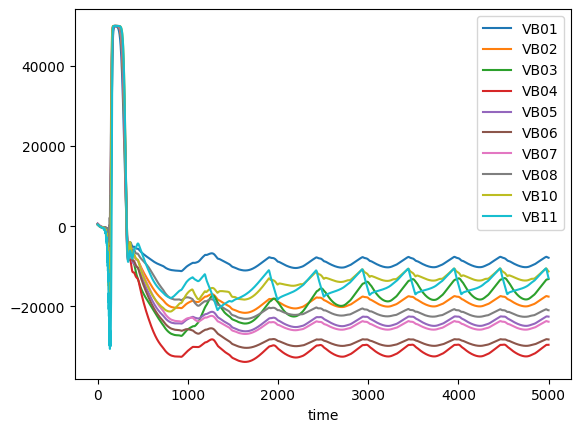

In [1300]:
# VD
VD = neurons[['VB01', 'VB02', 'VB03', 'VB04', 'VB05', 'VB06', 'VB07', 'VB08',  'VB10', 'VB11']]
VD_new = VD[(neurons.index > 0) ]
VD_new.plot()

<Axes: xlabel='time'>

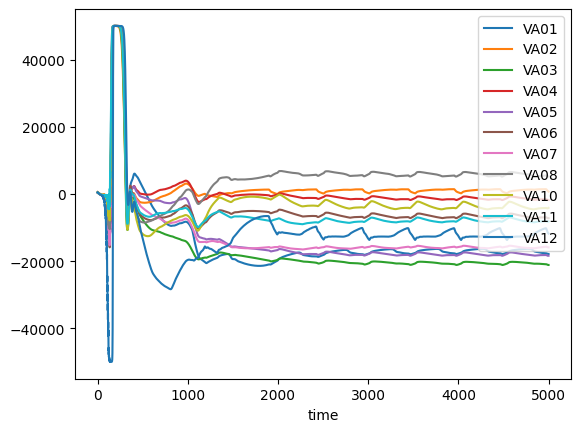

In [1301]:
# VA
VA = neurons[['VA01', 'VA02', 'VA03', 'VA04', 'VA05', 'VA06', 'VA07', 'VA08',  'VA10', 'VA11', 'VA12']]
VA_new = VA[(neurons.index > 0) ]
VA_transpose = VA_new.transpose()
VA_new.plot()

<Axes: xlabel='time'>

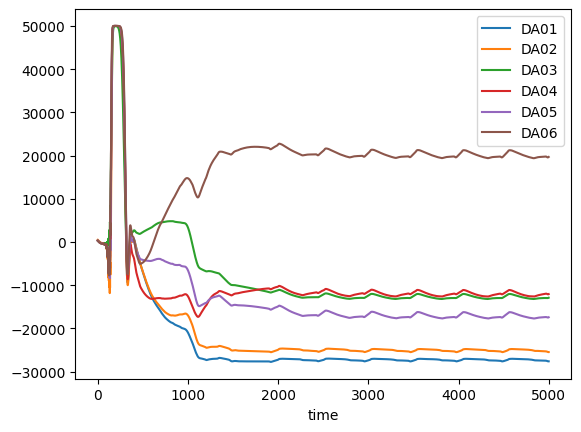

In [1302]:
# DA
DA = neurons[['DA01', 'DA02', 'DA03', 'DA04', 'DA05', 'DA06']]
DA_new = DA[(neurons.index > 0) ]
DA_new.plot()

<Axes: xlabel='time'>

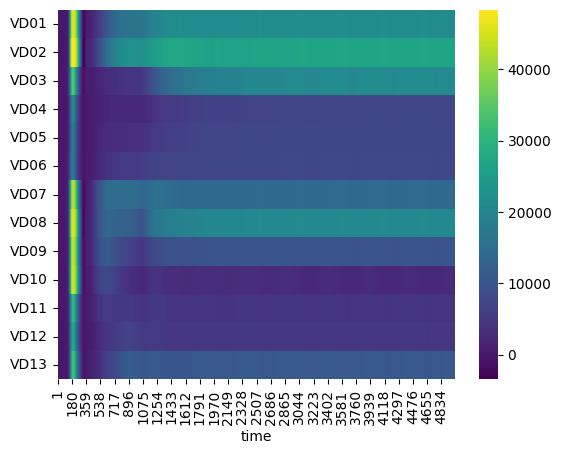

In [1303]:
# VD
VD = neurons[['VD01', 'VD02', 'VD03', 'VD04', 'VD05', 'VD06', 'VD07', 'VD08', 'VD09', 'VD10', 'VD11', 'VD12', 'VD13']]
VD_new = VD[(neurons.index > 0)]
VD_transpose = VD_new.transpose()
sns.heatmap(VD_transpose, cmap = 'viridis')

<Axes: xlabel='time'>

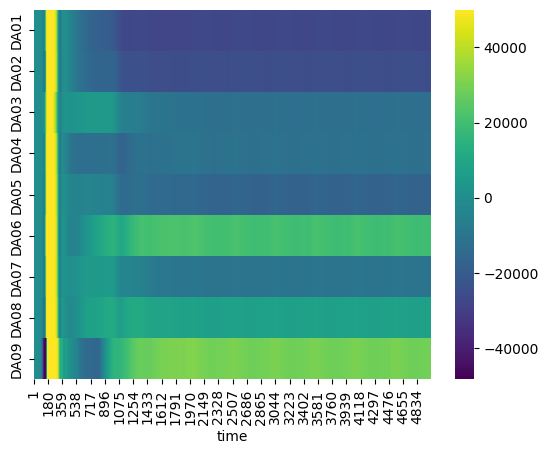

In [1304]:
# DA
DA = neurons[['DA01', 'DA02', 'DA03', 'DA04', 'DA05', 'DA06', 'DA07', 'DA08', 'DA09']]
DA_new = DA[(neurons.index > 0)]
DA_transpose = DA_new.transpose()
sns.heatmap(DA_transpose, cmap = 'viridis')

<Axes: xlabel='time'>

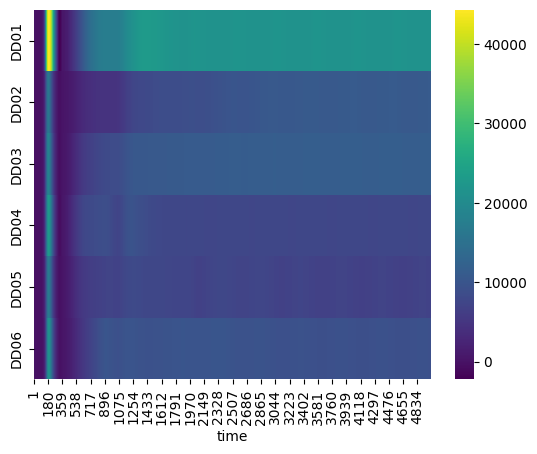

In [1305]:
# DD
DD = neurons[['DD01', 'DD02', 'DD03', 'DD04', 'DD05', 'DD06']]
DD_new = DD[(neurons.index > 0)]
DD_transpose = DD_new.transpose()
sns.heatmap(DD_transpose, cmap = 'viridis')

<Axes: xlabel='time'>

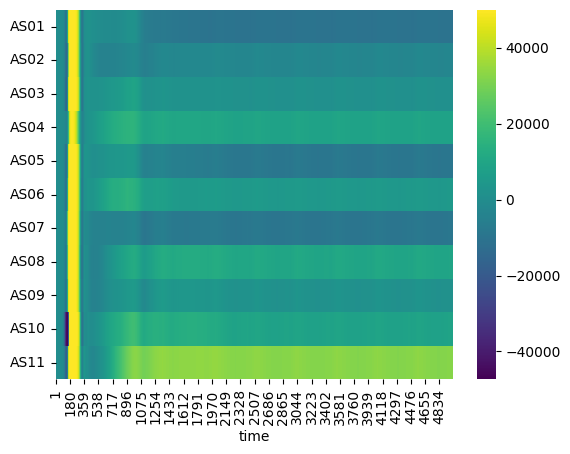

In [1306]:
# AS
AS = neurons[['AS01', 'AS02', 'AS03', 'AS04', 'AS05', 'AS06', 'AS07', 'AS08', 'AS09', 'AS10', 'AS11']]
AS_new = AS[(neurons.index > 0)]
AS_transpose = AS_new.transpose()
sns.heatmap(AS_transpose, cmap = 'viridis')

<Axes: xlabel='time'>

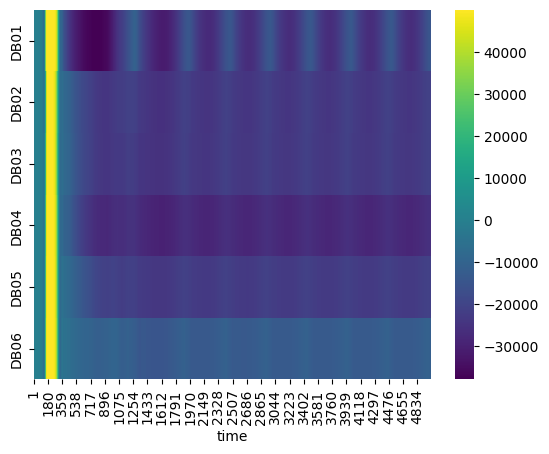

In [1307]:
# DB
DB= neurons[['DB01', 'DB02', 'DB03', 'DB04', 'DB05', 'DB06']]
DB_new = DB[(neurons.index > 0)]
DB_transpose = DB_new.transpose()
sns.heatmap(DB_transpose, cmap = 'viridis')

<Axes: xlabel='time'>

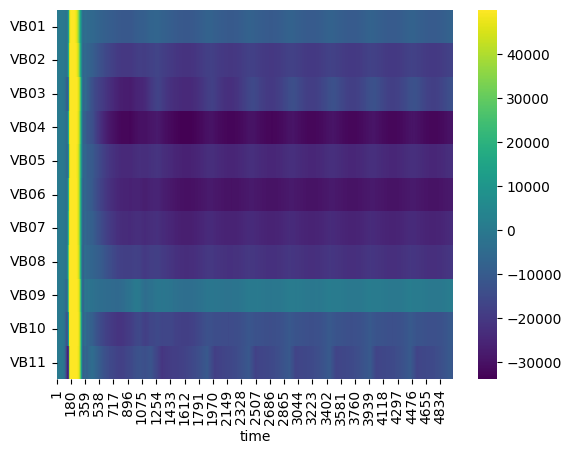

In [1308]:
# VB
VB= neurons[['VB01', 'VB02', 'VB03', 'VB04', 'VB05', 'VB06', 'VB07', 'VB08', 'VB09', 'VB10', 'VB11']]
VB_new = VB[(neurons.index > 0)]
VB_transpose = VB_new.transpose()
sns.heatmap(VB_transpose, cmap = 'viridis')

<Axes: xlabel='time'>

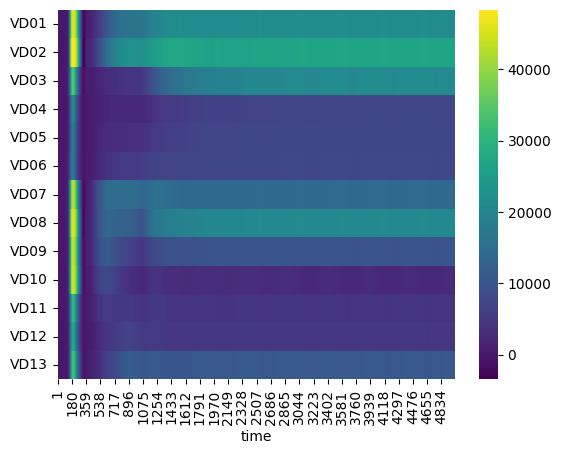

In [1309]:
# VD
VD= neurons[['VD01', 'VD02', 'VD03', 'VD04', 'VD05', 'VD06', 'VD07', 'VD08', 'VD09', 'VD10', 'VD11', 'VD12', 'VD13']]
VD_new = VD[(neurons.index > 0)]
VD_transpose = VD_new.transpose()
sns.heatmap(VD_transpose, cmap = 'viridis')

Text(50.722222222222214, 0.5, 'VA')

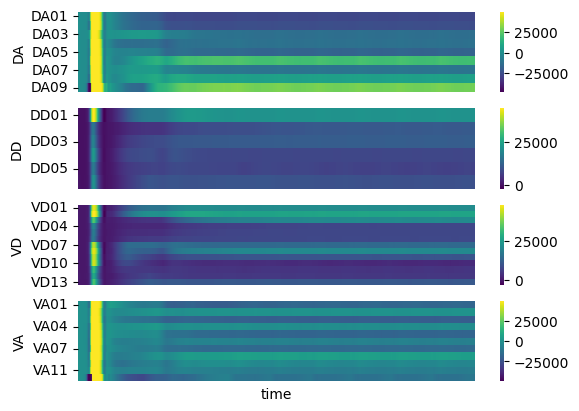

In [1310]:
import matplotlib.pyplot as plt
# plot all figures in one
f,(ax1,ax2,ax3, ax4) = plt.subplots(4,1)

g1 = sns.heatmap(DA_transpose,cmap = 'viridis',ax=ax1, xticklabels=False)
g1.set_ylabel('DA')
g1.set_xlabel('')
g2 = sns.heatmap(DD_transpose, cmap = 'viridis',ax=ax2, xticklabels=False)
g2.set_ylabel('DD')
g2.set_xlabel('')
g3 = sns.heatmap(VD_transpose, cmap='viridis',ax=ax3, xticklabels=False)
g3.set_ylabel('VD')
g3.set_xlabel('')
g4 = sns.heatmap(VA_transpose, cmap = 'viridis',ax=ax4, xticklabels=False)
g4.set_ylabel('VA')



Text(50.722222222222214, 0.5, 'VA')

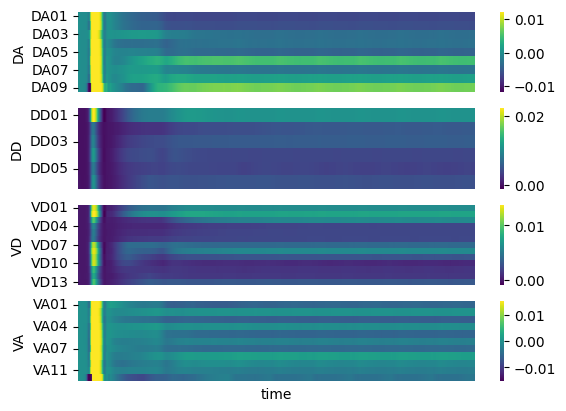

In [1311]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# normalize the data
DA_transpose_norm = np.linalg.norm(DA_transpose)
DD_transpose_norm = np.linalg.norm(DD_transpose)
VD_transpose_norm = np.linalg.norm(VD_transpose)
VA_transpose_norm = np.linalg.norm(VA_transpose)

DA_transpose_normalized = DA_transpose / DA_transpose_norm
DD_transpose_normalized = DD_transpose / DD_transpose_norm
VD_transpose_normalized = VD_transpose / VD_transpose_norm
VA_transpose_normalized = VA_transpose / VA_transpose_norm

# plot all figures in one
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)

g1 = sns.heatmap(DA_transpose_normalized, cmap='viridis', ax=ax1, xticklabels=False)
g1.set_ylabel('DA')
g1.set_xlabel('')
g2 = sns.heatmap(DD_transpose_normalized, cmap='viridis', ax=ax2, xticklabels=False)
g2.set_ylabel('DD')
g2.set_xlabel('')
g3 = sns.heatmap(VD_transpose_normalized, cmap='viridis', ax=ax3, xticklabels=False)
g3.set_ylabel('VD')
g3.set_xlabel('')
g4 = sns.heatmap(VA_transpose_normalized, cmap='viridis', ax=ax4, xticklabels=False)
g4.set_ylabel('VA')


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: 

Text(50.722222222222214, 0.5, 'VA')

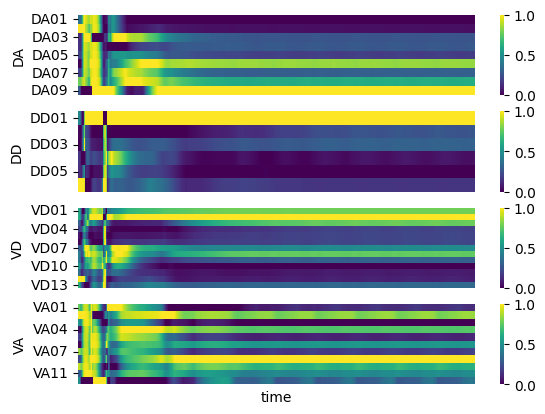

In [1312]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# normalize the data
DA_transpose_min = np.min(DA_transpose)
DA_transpose_max = np.max(DA_transpose)
DA_transpose_normalized = (DA_transpose - DA_transpose_min) / (DA_transpose_max - DA_transpose_min)

DD_transpose_min = np.min(DD_transpose)
DD_transpose_max = np.max(DD_transpose)
DD_transpose_normalized = (DD_transpose - DD_transpose_min) / (DD_transpose_max - DD_transpose_min)

VD_transpose_min = np.min(VD_transpose)
VD_transpose_max = np.max(VD_transpose)
VD_transpose_normalized = (VD_transpose - VD_transpose_min) / (VD_transpose_max - VD_transpose_min)

VA_transpose_min = np.min(VA_transpose)
VA_transpose_max = np.max(VA_transpose)
VA_transpose_normalized = (VA_transpose - VA_transpose_min) / (VA_transpose_max - VA_transpose_min)

# plot all figures in one
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)

g1 = sns.heatmap(DA_transpose_normalized, cmap='viridis', ax=ax1, xticklabels=False)
g1.set_ylabel('DA')
g1.set_xlabel('')
g2 = sns.heatmap(DD_transpose_normalized, cmap='viridis', ax=ax2, xticklabels=False)
g2.set_ylabel('DD')
g2.set_xlabel('')
g3 = sns.heatmap(VD_transpose_normalized, cmap='viridis', ax=ax3, xticklabels=False)
g3.set_ylabel('VD')
g3.set_xlabel('')
g4 = sns.heatmap(VA_transpose_normalized, cmap='viridis', ax=ax4, xticklabels=False)
g4.set_ylabel('VA')


Text(50.722222222222214, 0.5, 'VD')

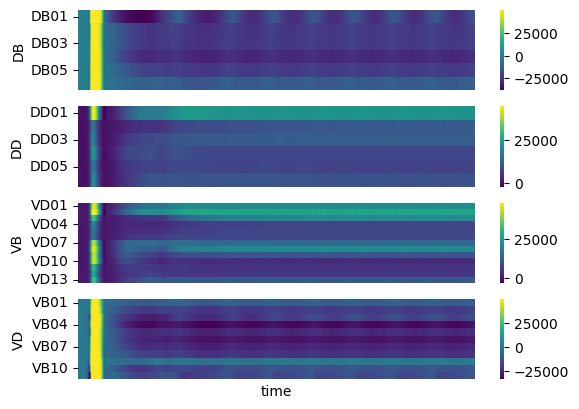

In [1313]:
import matplotlib.pyplot as plt
# plot all figures in one
f,(ax1,ax2,ax3, ax4) = plt.subplots(4,1)

g1 = sns.heatmap(DB_transpose,cmap = 'viridis',ax=ax1, xticklabels=False)
g1.set_ylabel('DB')
g1.set_xlabel('')
g2 = sns.heatmap(DD_transpose, cmap = 'viridis',ax=ax2, xticklabels=False)
g2.set_ylabel('DD')
g2.set_xlabel('')
g3 = sns.heatmap(VD_transpose, cmap='viridis',ax=ax3, xticklabels=False)
g3.set_ylabel('VB')
g3.set_xlabel('')
g4 = sns.heatmap(VB_transpose, cmap = 'viridis',ax=ax4, xticklabels=False)
g4.set_ylabel('VD')
